##### Model user’s skipping behavior: Build and estimate (or train) a model on the first 15,000 observations in the data (thetraining and validation sample) that provides the most accurate and robust predictionsof user skipping behavior on the last 5,000 observationsin the data (the hold-out sample).

#### Meaning of every song feature in the spotify

The provided dataset (a simplified subset of Spotify AI challenge) consisted of 9 acoustic features of songs and 2 target variables – ‘early skip’ and ‘late skip’. The meaning of the features is as follows:
1.	Duration: Duration or length of the song in seconds
2.	Acousticness: The confidence measure of how natural acoustic sounds it consists of. Lower acousticness means higher electric sounds. 1.0 represents high confidence the track is acoustic
3.	Danceability: The extent of how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 1.0 means most danceable
4.	Energy: A measure from 0.0 to 1.0 representing a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy
5.	Instrumentalness: Measure of whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. 1.0 indicates greater likelihood that the track contains no vocal content
6.	Liveliness: Detection of the presence of an audience in the recording. Higher liveliness representing increased probability that the track was performed live
7.	Loudness: Overall loudness of the track in decibels (dB). is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db
8.	Tempo: It is the speed or pace of a given piece derived directly from the average beat duration in bpm (beats per minute) 
9.	Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track
10.	Early: If song was skipped early or not. 1 indicating early skip while 0 could mean either a late skip or no skip
11.	Late: If song was skipped late or not. 1 indicating late skip while 0 indicating no skip. 


Note: ‘1’ in Early column had ‘1’ in late column as well


In [90]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [961]:
data_rounded=data.describe()
data_rounded=data_rounded.apply(lambda x: np.round(x,4))
data_rounded

,duration,acousticness,danceability,energy,instrumentalness,liveness,loudness,tempo,valence,early,late
count,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000
mean,219.4678,0.2253,0.6518,0.6346,0.0350,0.1895,-7.0106,122.4435,0.4752,0.5289,0.7042
std,61.8584,0.2515,0.1572,0.1887,0.1522,0.1528,3.2282,29.8700,0.2343,0.4992,0.4564
min,31.3981,0.0000,0.0000,0.0002,0.0000,0.0200,-51.1770,0.0000,0.0000,0.0000,0.0000
25%,185.8908,0.0300,0.5469,0.5122,0.0000,0.0984,-8.3710,97.0430,0.2877,0.0000,0.0000
50%,214.0467,0.1212,0.6687,0.6438,0.0000,0.1266,-6.3895,122.0990,0.4599,1.0000,1.0000
75%,246.3800,0.3446,0.7673,0.7795,0.0001,0.2358,-4.9178,142.9705,0.6506,1.0000,1.0000
max,875.3066,0.9958,0.9876,0.9998,0.9923,0.9919,0.1750,216.4620,0.9873,1.0000,1.0000


In [1055]:
data=pd.read_csv('spotify.csv')
data['early']=data['early'].apply(lambda x: int(x))
data['late']=data['late'].apply(lambda x: int(x))
data
df=data.copy()
df['skip_speed']=[df['early'][i]+df['late'][i] for i in range(df.shape[0])]
df.drop(['early','late'],axis=1,inplace=True)
#df['skip_speed']=df['skip_speed'].astype('category')
Final_Results_dict=dict()

In [1056]:
y=df.iloc[:,-1]
x=df.iloc[:,:-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=40,shuffle=True)


In [1057]:
######### Fitting scaler on train data #########
scaler=StandardScaler()
scaler.fit(x_train)


######## Scaling both train and test #########
x_train= scaler.transform(x_train)
x_test= scaler.transform(x_test)

duration float64
acousticness float64
danceability float64
energy float64
instrumentalness float64
liveness float64
loudness float64
tempo float64
valence float64
skip_speed int64


Text(0.5, 0, 'Skip Speed: [0:No skip, 1: Late Skip, 2:Early Skip]')

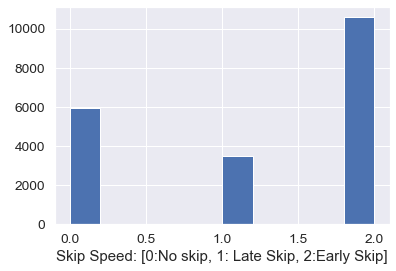

In [114]:
### checking the type of column
for col in df.columns:
    print(col,df[col].dtype)
## Hence, need to convert the skip speed intp categorical variables  
plt.hist(df['skip_speed'])
plt.xlabel('Skip Speed: [0:No skip, 1: Late Skip, 2:Early Skip]')

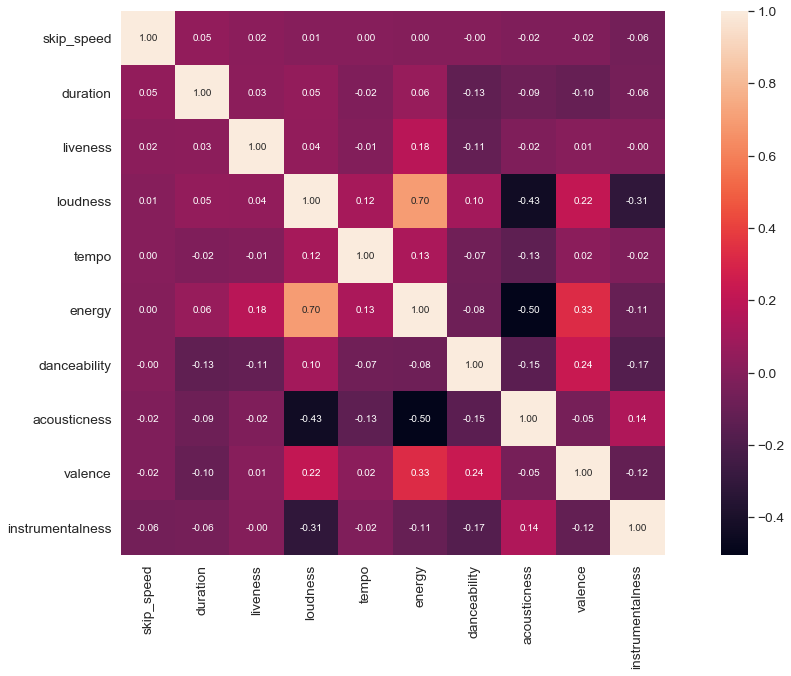

In [100]:
corrmat = df.corr()
plt.figure(figsize=(20,10))
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'skip_speed')['skip_speed'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [965]:
######creating train and validation datasets#####
x_train_partial,x_val,y_train_partial,y_val=train_test_split(x_train,y_train,test_size=0.25,random_state=40,shuffle=True)

### Multinomial logistic Regression

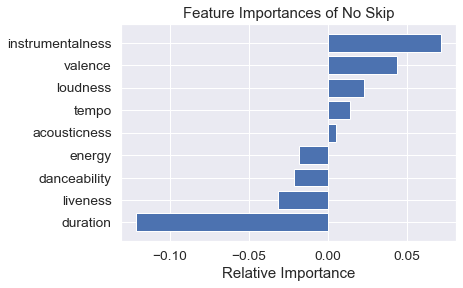

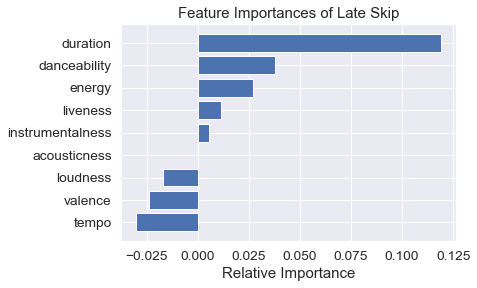

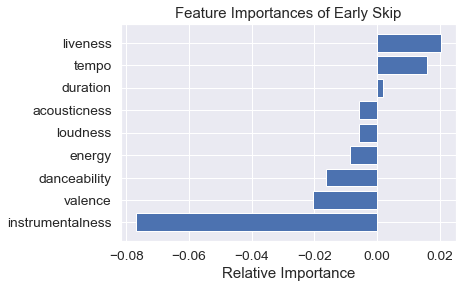

In [1058]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(multi_class='multinomial',solver='lbfgs').fit(x_train_partial,y_train_partial)
logreg.predict_proba(x_val)
log_loss(y_val,logreg.predict_proba(x_val))
logreg.coef_[0]

#print('Importances for class 0: No skip at all\n')
# for name, importance in zip(df.columns[:-1],logreg.coef_[0]):
#     print(name,'=',importance)
   
classes=['No Skip','Late Skip','Early Skip']
#fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#fig=plt.figure((1,3,i))
for j in range(1,4):
    features=df.columns[:-1]
    importance=logreg.coef_[j-1]
    indices=np.argsort(importance)
    ax = fig.add_subplot(1, 3, j)
    plt.title(f'Feature Importances of {classes[j-1]}')
    #ax.subplot(1,3,j)
    plt.barh(range(len(indices)),importance[indices],align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [1068]:
log_loss(y_test,logreg.predict_proba(x_test))
logreg.score(x_test,y_test)
#logreg.predict(x_test)

0.5386

### K Nearest Neighbours

Text(0.5, 0, 'Number of Neighbours')

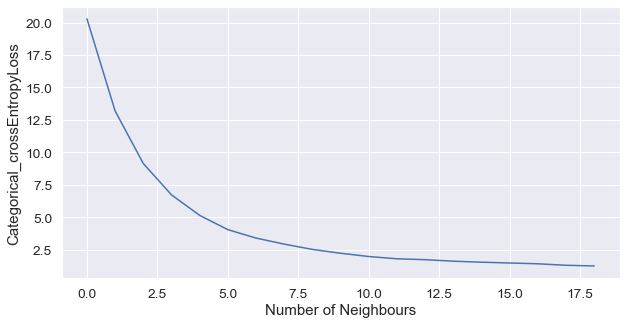

In [176]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss

method='K nearest Neighbours'
neighbour_grid=np.arange(1,20)
result_dict=dict()
for num_neigh in neighbour_grid:
    model1=KNeighborsClassifier(n_neighbors=num_neigh)
    model1.fit(x_train_partial,np.array(y_train_partial))
    predicted=model1.predict_proba(x_val)
    loss=log_loss(np.array(y_val),predicted)
    result_dict[num_neigh]=loss

fig=plt.figure(figsize=(10,5))
plt.plot(list(result_dict.values()))
plt.ylabel('Categorical_crossEntropyLoss')
plt.xlabel('Number of Neighbours')


In [171]:
#### From the plot above, choosing 4 as the best nearest neighbours
num_neigh=4
method='K nearest Neighbours'
### Training on entire train and then Checking on test
model1=KNeighborsClassifier(n_neighbors=num_neigh)
model1.fit(x_train,np.array(y_train))
predicted=model1.predict_proba(x_test)
loss=log_loss(np.array(y_test),predicted)
print(f'Choosing {num_neigh} as the number of nearest neighbours, Log loss for Knearest neighbours method is {loss}.')
Final_Results_dict[method]=dict()
Final_Results_dict[method]['Log_Loss']=loss
Final_Results_dict[method]['Accuracy']=model1.score(x_test,y_test)

Choosing 4 as the number of nearest neighbours, Log loss for Knearest neighbours method is 6.528984707106509.


In [408]:
Final_Results_dict[method]['Accuracy']

0.4176

### SVM

Note: In case of support vector classifier, the fit time scales quadratically with the number of samples

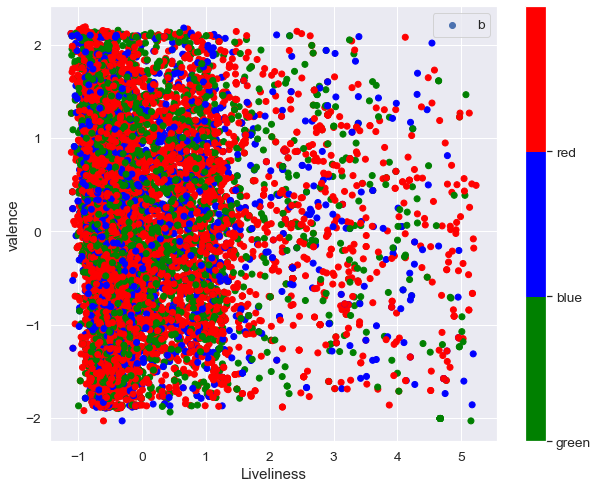

In [218]:
import matplotlib
colors = ['green','blue','red']
label=np.array([y_train])
fig = plt.figure(figsize=(10,8))
# for i in range(28)
# fig=plt.subplot(4,7,i+1)
plt.scatter(np.array([x_train[:,5]]), np.array([x_train[:,8]]), c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(list(label[0])),max(list(label[0]))/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)
plt.xlabel('Liveliness')
plt.ylabel('valence')
plt.legend('best')

#Red is early skip, blue is late skip and green is no skip

#### We will use One Vs Rest as the data is imbalanced and also it is computationally less expensive as compared to One vs one

In [295]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#scaled_svc=make_pipeline(StandardScaler(),SVC())
param_grid={'svc__C':np.logspace(-3,2,6),
            'svc__gamma': np.logspace(-3,2,6)/x_train_partial.shape[0]}

#grid=GridSearchCV(scaled_svc,param_grid=param_grid,cv=10)
#results=grid.fit(x_train,y_train)
svc_results_grid=dict()
gamma_grid=np.logspace(-3,2,6)/x_train_partial.shape[0]
c_grid=np.logspace(-3,2,6)
for gamma in gamma_grid:
    for c in c_grid:
        svc=SVC(gamma=gamma,C=c)
        svc.fit(x_train_partial,y_train_partial)
        score=svc.score(x_val,y_val)
        svc_results_grid[(gamma,c)]=score

In [1071]:
#svc_results_grid
svc=SVC(gamma=0.0088,C=100,probability=True)
svc.fit(x_train,y_train)
score=svc.score(x_val,y_val)
log_loss(np.array(y_test),svc.predict_proba(x_test))

0.994220746560595

In [893]:
log_loss(np.array(y_test),svc.predict_proba(x_test))

0.994499210788227

In [1072]:
svc.score(x_test,y_test)

0.5392

### Neural Network

In [336]:
from keras import models
from keras import layers
from keras import metrics
from keras import optimizers

dataset=x_train
def build_model(dropout=0.3,nodes=32):
    model=models.Sequential()
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr=0.01, decay=1e-6)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[metrics.categorical_accuracy])
    return model

In [374]:
model=build_model(dropout=0.6)
model.summary()

y_train_nn=pd.get_dummies(pd.DataFrame(y_train_partial))
y_val_nn=pd.get_dummies(pd.DataFrame(y_val))


history=model.fit(x_train_partial,y_train_nn,validation_data=(x_val,y_val_nn),epochs=200,verbose=0,batch_size=100)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)             

##### Simplest neural network with 1 hidden layer of 32 neurons - to be used as baseline for hyperparameter tuning

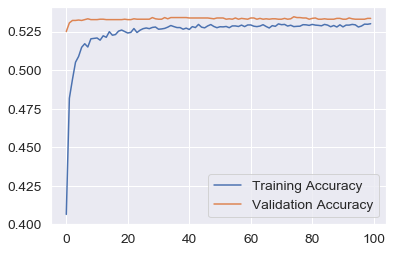

In [311]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()


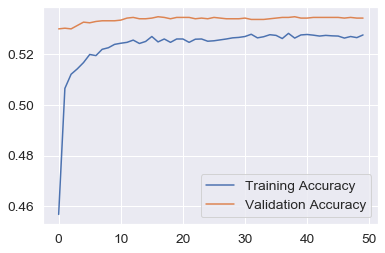

In [322]:
plt.plot(history.history['categorical_accuracy'],label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

#### Adam optimizers

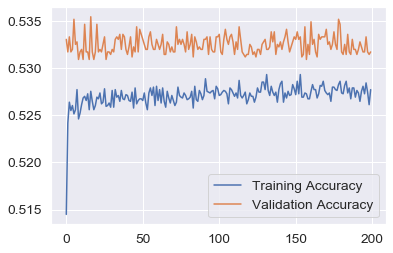

0.5277333
0.5317333340644836


In [338]:
plt.plot(history.history['categorical_accuracy'],label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['categorical_accuracy'][-1])
print(history.history['val_categorical_accuracy'][-1])

In [357]:
y_test_nn=pd.get_dummies(pd.DataFrame(y_test.astype('category')))
model.evaluate(x_test,y_test_nn)

5000/5000 [==============================] - 0s 29us/step


[0.9955488874435425, 0.5382000207901001]

In [406]:
def build_model(dropout=0.3,nodes=64):
    model=models.Sequential()
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(int(nodes/2),activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    model.add(layers.Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['acc'])
    return model


model=build_model()
model.summary()

y_train_nn=pd.get_dummies(pd.DataFrame(y_train_partial))
y_val_nn=pd.get_dummies(pd.DataFrame(y_val))


history=model.fit(x_train_partial,y_train_nn,validation_data=(x_val,y_val_nn),epochs=200,verbose=0,batch_size=100)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)             

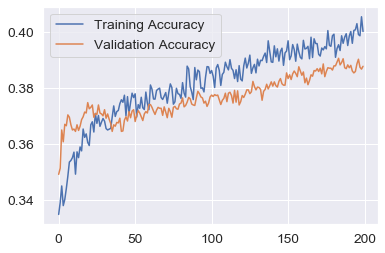

0.40032652
0.3878757059574127


In [407]:
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

#### As the accuracy is lying only around 50%, let's try to balance the dataset

##### Over sampling

In [373]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

     |████████████████████████████████| 163 kB 1.3 MB/s eta 0:00:01


In [377]:
smote=SMOTE('minority')
x_sm,y_sm=smote.fit_sample(x_train,y_train)
x_sm.shape,y_sm.shape

((20246, 9), (20246,))

/Users/ishagupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


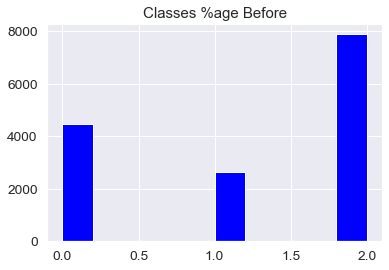

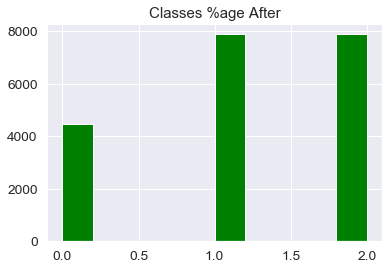

In [392]:
ys=[y_train,y_sm]
color=['blue','green']
when=['Before','After']
for j in range(1,3):
    ax=fig.add_subplot(1,2,j)
    plt.hist(ys[j-1],color=color[j-1])
    plt.title(f'Classes %age {when[j-1]}')
    plt.show()


In [398]:
x_train_partial,x_val,y_train_partial,y_val=train_test_split(x_sm,y_sm,test_size=0.25)

y_train_nn=pd.get_dummies(pd.DataFrame(y_train_partial))
y_val_nn=pd.get_dummies(pd.DataFrame(y_val))


history=model.fit(x_train_partial,y_train_nn,validation_data=(x_val,y_val_nn),epochs=200,verbose=0,batch_size=100)

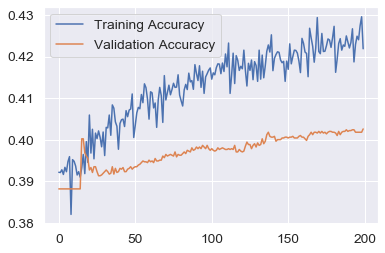

0.42189145
0.40260767936706543


In [399]:
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

In [400]:
y_test_nn=pd.get_dummies(pd.DataFrame(y_test.astype('category')))
model.evaluate(x_test,y_test_nn)

5000/5000 [==============================] - 0s 37us/step


[1.143806499862671, 0.19059999287128448]

In [402]:
smote=SMOTE('minority')
x_sm_new,y_sm_new=smote.fit_sample(x_sm,y_sm)

/Users/ishagupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


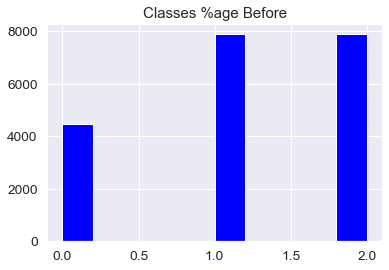

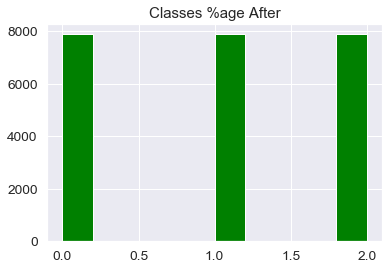

In [403]:
ys=[y_sm,y_sm_new]
color=['blue','green']
when=['Before','After']
for j in range(1,3):
    ax=fig.add_subplot(1,2,j)
    plt.hist(ys[j-1],color=color[j-1])
    plt.title(f'Classes %age {when[j-1]}')
    plt.show()


In [404]:
x_train_partial,x_val,y_train_partial,y_val=train_test_split(x_sm_new,y_sm_new,test_size=0.25,shuffle=True)

y_train_nn=pd.get_dummies(pd.DataFrame(y_train_partial))
y_val_nn=pd.get_dummies(pd.DataFrame(y_val))


history=model.fit(x_train_partial,y_train_nn,validation_data=(x_val,y_val_nn),epochs=200,verbose=0,batch_size=100)

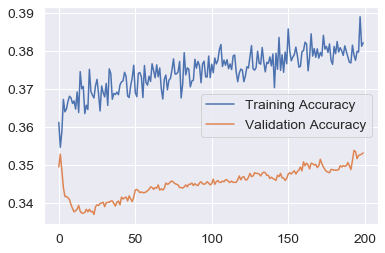

0.38225526
0.35325902700424194


In [405]:
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

### Trees

In [425]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

x_train_partial,x_val,y_train_partial,y_val=train_test_split(x_train,y_train,test_size=0.25)

depths=np.arange(1,15)
tree_grid=dict()
tree_grid['max_depth']=dict()
for depth in depths:
    tree_1=DecisionTreeClassifier(splitter='best',max_depth=depth,random_state=42)
    tree_1.fit(x_train_partial,y_train_partial)
    score=tree_1.score(x_val,y_val)
    tree_grid['max_depth'][depth]=score
    
    
# taking max_depth as 3


In [451]:
alphas=np.arange(1,10000,100)

tree_grid['Alpha']=dict()
for alpha in alphas:
    tree_1=DecisionTreeClassifier(splitter='best',max_depth=3,random_state=42,ccp_alpha=alpha)
    tree_1.fit(x_train_partial,y_train_partial)
    score=tree_1.score(x_val,y_val)
    tree_grid['Alpha'][alpha]=score

In [966]:
tree_1=DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42,ccp_alpha=0.4)
tree_1.fit(x_train,y_train)
tree_1.score(x_test,y_test)

0.5366

In [968]:
log_loss(np.array(y_test),tree_1.predict_proba(x_test))

0.9959110886736525

In [970]:
tree_g=GradientBoostingClassifier(random_state=42,max_depth=3,n_estimators=100)
tree_g.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [1073]:
log_loss(np.array(y_test),tree_g.predict_proba(x_test))
tree_g.score(x_test,y_test)

0.538

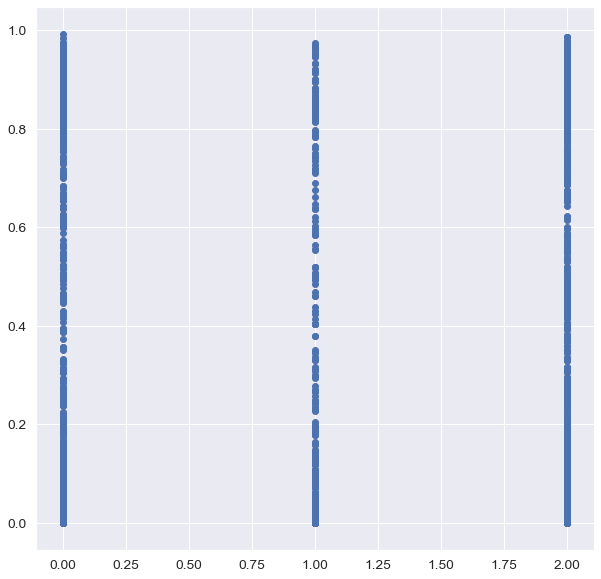

In [603]:
import seaborn as sns
fig=plt.figure(figsize=(10,10))
#sns.boxplot(x="skip_speed", y="instrumentalness", data=df)
plt.scatter(x="skip_speed", y="instrumentalness", data=df)

,duration,acousticness,danceability,energy,instrumentalness,liveness,loudness,tempo,valence,skip_speed,skip_at_all
0,356.600006,0.246817,0.682989,0.551150,2.120000e-05,0.047128,-10.164,124.584999,0.961799,0,0
1,285.746674,0.130157,0.649913,0.619879,6.250000e-08,0.076409,-8.437,78.024002,0.725308,2,1
2,285.746674,0.130157,0.649913,0.619879,6.250000e-08,0.076409,-8.437,78.024002,0.725308,1,1
3,249.119995,0.150626,0.760955,0.598114,2.588208e-03,0.031358,-5.838,103.977997,0.937014,2,1
4,228.923080,0.145012,0.792451,0.689618,9.070000e-09,0.098796,-7.118,130.057007,0.435938,2,1
...,...,...,...,...,...,...,...,...,...,...,...
19995,318.000000,0.000258,0.362474,0.701124,7.790000e-05,0.072693,-8.401,105.742996,0.190570,2,1
19996,318.000000,0.000258,0.362474,0.701124,7.790000e-05,0.072693,-8.401,105.742996,0.190570,2,1
19997,211.573334,0.313445,0.669488,0.510981,9.120000e-07,0.135029,-11.016,82.864998,0.398425,2,1
19998,211.684906,0.167160,0.784435,0.608155,1.340000e-10,0.087071,-5.885,90.712997,0.381874,2,1


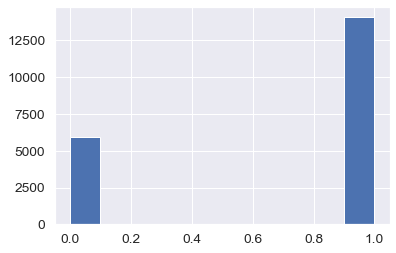

In [922]:
df['skip_at_all']=np.where(df['skip_speed']==0,0,1)
plt.hist(df['skip_at_all'])
#df['skip_at_all']=df['skip_at_all'].astype('category')
df

### Creating classifiers across 'skip' vs 'no-skip' classes first

In [1022]:
data=pd.read_csv('spotify.csv')
data['early']=data['early'].apply(lambda x: int(x))
data['late']=data['late'].apply(lambda x: int(x))
df_=data.copy()
#df_['skip_at_all']=df_['skip_at_all'].astype('category')
y=df_.iloc[:,-1]
x=df_.iloc[:,:-2]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=40,shuffle=True)

######### Fitting scaler on train data #########
scaler=StandardScaler()
scaler.fit(x_train)


######## Scaling both train and test #########
x_train= scaler.transform(x_train)
x_test= scaler.transform(x_test)

x_train_p,x_valid,y_train_p,y_valid=train_test_split(x_train,y_train,test_size=0.25,random_state=40,shuffle=True)

### Logistic Regression


In [1034]:
pd.get_dummies(pd.DataFrame(y_train_p).astype('category'))

,late_0,late_1
14921,0,1
14936,0,1
255,1,0
6166,0,1
8256,0,1
...,...,...
15,0,1
8487,1,0
19311,0,1
16277,1,0


In [1035]:
def build_model(dropout=0.3,nodes=64):
    model=models.Sequential()
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(int(nodes/2),activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    model.add(layers.Dense(2,activation='softmax'))

    adam = optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['acc'])
    return model


model=build_model()
model.summary()

y_train_nn=pd.get_dummies(pd.DataFrame(y_train_p).astype('category'))
y_val_nn=pd.get_dummies(pd.DataFrame(y_valid).astype('category'))


history=model.fit(x_train_p,y_train_nn,validation_data=(x_valid,y_val_nn),epochs=200,verbose=0,batch_size=100)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 64)                640       
_________________________________________________________________
dropout_99 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_100 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_101 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_133 (Dense)            (None, 128)             

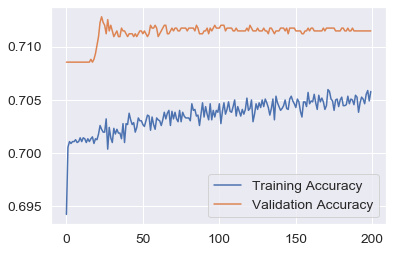

0.70577776
0.7114666700363159


In [1036]:
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

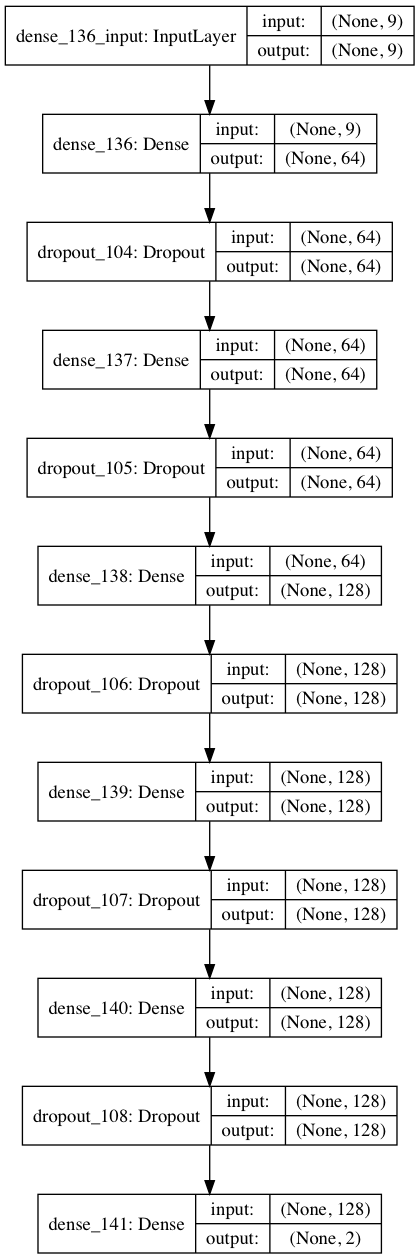

In [1075]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 64)                640       
_________________________________________________________________
dropout_76 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_78 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 128)             

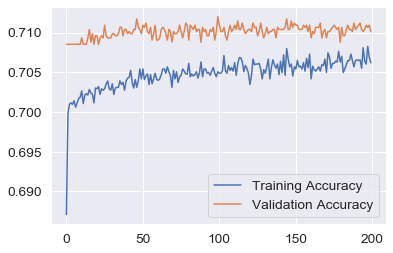

0.70622224
0.7101333141326904


In [482]:
def build_model(dropout=0.3,nodes=64):
    model=models.Sequential()
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(int(nodes/2),activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    model.add(layers.Dense(2,activation='softmax'))

    #adam = optimizers.Adam(lr=0.0001)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    print(model.summary())
    return model


model_=build_model(dropout=0.5)


y_train_nn=pd.get_dummies(pd.DataFrame(y_train_p))
y_val_nn=pd.get_dummies(pd.DataFrame(y_valid))


history=model_.fit(x_train_p,y_train_nn,validation_data=(x_valid,y_val_nn),epochs=200,verbose=0,batch_size=100)
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

In [1045]:
log_loss(y_test,model.predict_proba(x_test))


0.5580444994322518

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 32)                320       
_________________________________________________________________
dropout_80 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_81 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_82 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 64)              

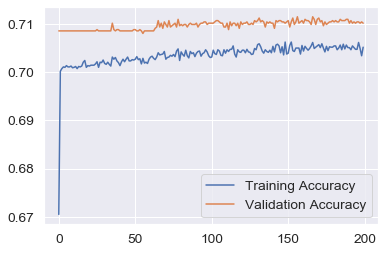

0.70515555
0.7101333141326904


In [483]:
model_=build_model(dropout=0.5,nodes=32)


y_train_nn=pd.get_dummies(pd.DataFrame(y_train_p))
y_val_nn=pd.get_dummies(pd.DataFrame(y_valid))


history=model_.fit(x_train_p,y_train_nn,validation_data=(x_valid,y_val_nn),epochs=200,verbose=0,batch_size=100)
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
#plt.plot(history.history['val_mae'],label='MAE')
#plt.plot(history.history['mape'])
#plt.plot(history.history['cosine'],label='Cosine')
plt.legend(loc='best')
plt.show()

print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

In [484]:
from sklearn.ensemble import GradientBoostingClassifier
depths=np.arange(1,15)
tree_grid=dict()
tree_grid['max_depth']=dict()
for depth in depths:
    tree_1=DecisionTreeClassifier(splitter='best',max_depth=depth,random_state=42)
    tree_1.fit(x_train_p,y_train_p)
    score=tree_1.score(x_valid,y_valid)
    tree_grid['max_depth'][depth]=score

In [485]:
tree_grid['max_depth']

{1: 0.7082666666666667,
 2: 0.7109333333333333,
 3: 0.7106666666666667,
 4: 0.7096,
 5: 0.7085333333333333,
 6: 0.708,
 7: 0.7029333333333333,
 8: 0.7061333333333333,
 9: 0.704,
 10: 0.6954666666666667,
 11: 0.6832,
 12: 0.6813333333333333,
 13: 0.6688,
 14: 0.6744}

In [502]:
num_trees=np.arange(10,1000,100)
grid_num_trees=dict()
for n in num_trees:
    tree_1=GradientBoostingClassifier(random_state=42,max_depth=3,n_estimators=n)
    tree_1.fit(x_train_p,y_train_p)
    score=tree_1.score(x_valid,y_valid)
    grid_num_trees[n]=score

In [504]:
tree_1=GradientBoostingClassifier(random_state=42,max_depth=3,n_estimators=5000)
tree_1.fit(x_train_p,y_train_p)
score=tree_1.score(x_valid,y_valid)
score

0.6464

In [513]:
tree_1=GradientBoostingClassifier(random_state=42,max_depth=3,n_estimators=110)
tree_1.fit(x_train,y_train)
tree_1.score(x_test,y_test)


0.712

#### As evident, the overall accuracy of the classifier is increased from 53% to 71% which shows that it is better and more reliable to first classify if the song will be skipped at all or not and make first level of recommendations and then conditioned on being skipped, creating another classifier if a song will be skipped early or late

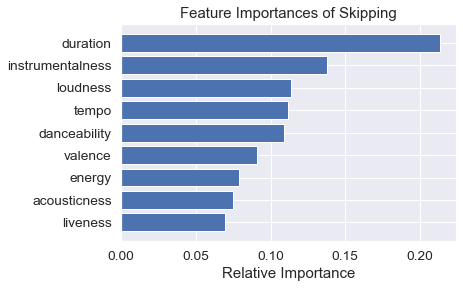

In [516]:

features=x.columns
importance=tree_1.feature_importances_
indices=np.argsort(importance)

plt.title(f'Feature Importances of Skipping')
#ax.subplot(1,3,j)
plt.barh(range(len(indices)),importance[indices],align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###### The plot shows the 'importance' or 'contribution' of a feature in making a listener skip a song. As evident, most contributing features are  - duration of song, instrumentalness, loudness, tempo, danceability and valence.

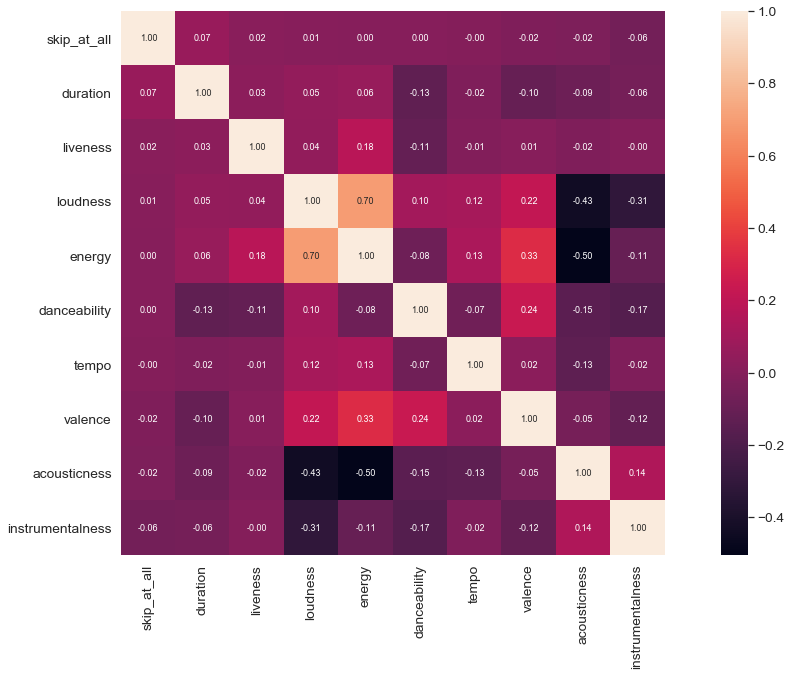

In [608]:
corrmat = df.drop(['skip_speed'],axis=1).corr()
plt.figure(figsize=(20,10))
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'skip_at_all')['skip_at_all'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Creating a decision tree doesn't hamper the accuracy of the classifier but it provides a good visualization and interpretability as compared to black box of neural network or ensemble of gradient boosting. And hence, it will be used to make final recommendations

In [923]:
df

,duration,acousticness,danceability,energy,instrumentalness,liveness,loudness,tempo,valence,skip_speed,skip_at_all
0,356.600006,0.246817,0.682989,0.551150,2.120000e-05,0.047128,-10.164,124.584999,0.961799,0,0
1,285.746674,0.130157,0.649913,0.619879,6.250000e-08,0.076409,-8.437,78.024002,0.725308,2,1
2,285.746674,0.130157,0.649913,0.619879,6.250000e-08,0.076409,-8.437,78.024002,0.725308,1,1
3,249.119995,0.150626,0.760955,0.598114,2.588208e-03,0.031358,-5.838,103.977997,0.937014,2,1
4,228.923080,0.145012,0.792451,0.689618,9.070000e-09,0.098796,-7.118,130.057007,0.435938,2,1
...,...,...,...,...,...,...,...,...,...,...,...
19995,318.000000,0.000258,0.362474,0.701124,7.790000e-05,0.072693,-8.401,105.742996,0.190570,2,1
19996,318.000000,0.000258,0.362474,0.701124,7.790000e-05,0.072693,-8.401,105.742996,0.190570,2,1
19997,211.573334,0.313445,0.669488,0.510981,9.120000e-07,0.135029,-11.016,82.864998,0.398425,2,1
19998,211.684906,0.167160,0.784435,0.608155,1.340000e-10,0.087071,-5.885,90.712997,0.381874,2,1


#### Skipped vs not skipped

In [1016]:
df_=df.copy()
#df_['skip_at_all']=df_['skip_at_all'].astype('category')
y=df_.iloc[:,-1]
x=df_.iloc[:,:-2]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=40,shuffle=True)

######### Fitting scaler on train data #########
scaler=StandardScaler()
scaler.fit(x_train)


######## Scaling both train and test #########
x_train= scaler.transform(x_train)
x_test= scaler.transform(x_test)

x_train_p,x_valid,y_train_p,y_valid=train_test_split(x_train,y_train,test_size=0.25,random_state=40,shuffle=True)

### Logistic Regression

In [896]:
ratios=np.arange(0.9,0.99,0.005)
best_loss_dict=dict()
for ratio in ratios:
    logreg=LogisticRegression(multi_class='multinomial',solver='saga',penalty='elasticnet',l1_ratio=ratio).fit(x_train_p,y_train_p)
    logreg.predict_proba(x_valid)
    loss=log_loss(y_valid,logreg.predict_proba(x_valid))
    best_loss_dict[ratio]=loss

Dictionary for best l1 ratio
 {0.9: 0.9985278194075048, 0.905: 0.9985280178763584, 0.91: 0.998527873321518, 0.915: 0.9985281219097742, 0.92: 0.9985280924847898, 0.925: 0.9985286941087984, 0.93: 0.998528403941413, 0.935: 0.9985284978704997, 0.9400000000000001: 0.9985284339681758, 0.9450000000000001: 0.9985286340812826, 0.9500000000000001: 0.998528646082952, 0.9550000000000001: 0.9985286558303896, 0.9600000000000001: 0.9985286230313434, 0.9650000000000001: 0.9985289836111245, 0.9700000000000001: 0.9985288993457685, 0.9750000000000001: 0.9985289692594016, 0.9800000000000001: 0.9985290483042764, 0.9850000000000001: 0.9985291555673049}


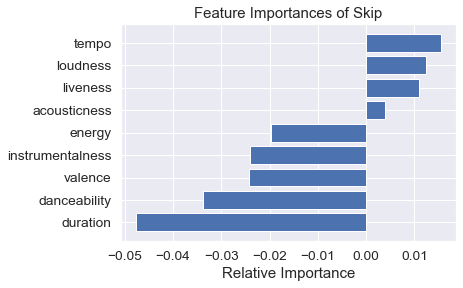

In [1017]:
print('Dictionary for best l1 ratio\n',best_loss_dict) #Hence 0.945 is the best l1ratio
logreg_1=LogisticRegression(multi_class='multinomial',solver='saga',penalty='elasticnet',l1_ratio=0.945).fit(x_train,y_train)
log_loss(y_test,logreg_1.predict_proba(x_test))

   
classes=['Skip']
#fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#fig=plt.figure((1,3,i))

features=df.columns[:-1]
importance=logreg_2.coef_[0]
indices=np.argsort(importance)

plt.title(f'Feature Importances of {classes[0]}')
#ax.subplot(1,3,j)
plt.barh(range(len(indices)),importance[indices],align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [1020]:
log_loss(y_test,logreg_1.predict_proba(x_test))
logreg_1.score(x_test,y_test)

0.5382

#### SVM

In [983]:
svc=SVC(gamma=0.0088,C=100,probability=True)
svc.fit(x_train,y_train)
score=svc.score(x_valid,y_valid)
log_loss(np.array(y_test),svc.predict_proba(x_test))
svc.score(x_test,y_test)

In [1021]:
log_loss(np.array(y_test),svc.predict_proba(x_test))
svc.score(x_test,y_test)

0.5402

In [979]:
from sklearn import tree

tree_1=DecisionTreeClassifier(splitter='best',max_depth=3,random_state=42)
tree_1.fit(x_train,y_train)
tree_1.score(x_train,y_train)


0.5316

In [978]:
y_train=y_train.astype('category')
tree_1=DecisionTreeClassifier(splitter='best',max_depth=3,random_state=42)
tree_1.fit(x_train,y_train)
tree_1.score(x_test,y_test)

0.5408

In [980]:
log_loss(np.array(y_test),tree_1.predict_proba(x_test))

0.9952159108327807

In [981]:
tree_1=GradientBoostingClassifier(random_state=42,max_depth=3,n_estimators=110)
tree_1.fit(x_train,y_train)
tree_1.score(x_test,y_test)

0.5374

In [982]:
log_loss(np.array(y_test),tree_1.predict_proba(x_test))

0.9951800708854549

In [936]:
import graphviz 
dot_data = tree.export_graphviz(tree_1, out_file=None, 
                      feature_names=df.columns[:-2],  
                      class_names=['Not_skipped','skipped'],  
                      filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)  
graph
graph.render(filename='g1.png')

'g1.png.pdf'

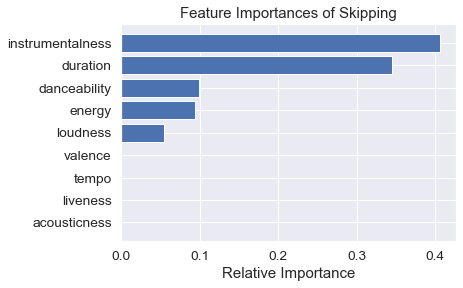

In [640]:
features=x.columns
importance=tree_1.feature_importances_
indices=np.argsort(importance)

plt.title(f'Feature Importances of Skipping')
#ax.subplot(1,3,j)
plt.barh(range(len(indices)),importance[indices],align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Early vs late skip IF skipped

In [993]:
df_=df.copy()
df_['skip_at_all']=np.where(df_['skip_speed']==0,0,1)
df_=df_[df_['skip_at_all']==1].drop(['skip_at_all'],axis=1)
df_['skip_speed']=df_['skip_speed'].apply(lambda x: x//2)
df_

,duration,acousticness,danceability,energy,instrumentalness,liveness,loudness,tempo,valence,skip_speed
1,285.746674,0.130157,0.649913,0.619879,6.250000e-08,0.076409,-8.437,78.024002,0.725308,1
2,285.746674,0.130157,0.649913,0.619879,6.250000e-08,0.076409,-8.437,78.024002,0.725308,0
3,249.119995,0.150626,0.760955,0.598114,2.588208e-03,0.031358,-5.838,103.977997,0.937014,1
4,228.923080,0.145012,0.792451,0.689618,9.070000e-09,0.098796,-7.118,130.057007,0.435938,1
5,107.217049,0.096282,0.754761,0.779972,4.220000e-06,0.103202,-3.461,129.774002,0.039749,0
...,...,...,...,...,...,...,...,...,...,...
19995,318.000000,0.000258,0.362474,0.701124,7.790000e-05,0.072693,-8.401,105.742996,0.190570,1
19996,318.000000,0.000258,0.362474,0.701124,7.790000e-05,0.072693,-8.401,105.742996,0.190570,1
19997,211.573334,0.313445,0.669488,0.510981,9.120000e-07,0.135029,-11.016,82.864998,0.398425,1
19998,211.684906,0.167160,0.784435,0.608155,1.340000e-10,0.087071,-5.885,90.712997,0.381874,1


In [1040]:
df_=df.copy()
df_['skip_at_all']=np.where(df_['skip_speed']==0,0,1)
df_=df_[df_['skip_at_all']==1].drop(['skip_at_all'],axis=1)
df_['skip_speed']=df_['skip_speed'].apply(lambda x: x//2)
#df_['skip_speed']=df_['skip_speed'].astype('category')
y=df_.iloc[:,-1]
x=df_.iloc[:,:-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=40,shuffle=True)

######### Fitting scaler on train data #########
scaler=StandardScaler()
scaler.fit(x_train)


######## Scaling both train and test #########
x_train= scaler.transform(x_train)
x_test= scaler.transform(x_test)

x_train_p,x_valid,y_train_p,y_valid=train_test_split(x_train,y_train,test_size=0.25,random_state=40,shuffle=True)

### SVM

In [1053]:
svc_2=SVC(gamma=0.0088,C=100,probability=True)
svc_2.fit(x_train,y_train)
score=svc_2.score(x_valid,y_valid)
log_loss(np.array(y_test),svc_2.predict_proba(x_test))
svc_2.score(x_test,y_test)

0.7560352172678216

In [1054]:
log_loss(np.array(y_test),svc_2.predict_proba(x_test))

0.5552833949815184

### Neural Network

In [1041]:
def build_model(dropout=0.3,nodes=64):
    model=models.Sequential()
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nodes*2,activation='relu',input_shape=(dataset.shape[1],)))
    model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(nodes,activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(int(nodes/2),activation='relu',input_shape=(dataset.shape[1],)))
    #model.add(layers.Dropout(dropout))
    model.add(layers.Dense(2,activation='softmax'))

    adam = optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['acc'])
    return model


model=build_model()
model.summary()

y_train_nn=pd.get_dummies(pd.DataFrame(y_train_p).astype('category'))
y_val_nn=pd.get_dummies(pd.DataFrame(y_valid).astype('category'))


history=model.fit(x_train_p,y_train_nn,validation_data=(x_valid,y_val_nn),epochs=200,verbose=0,batch_size=100)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 64)                640       
_________________________________________________________________
dropout_104 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_137 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_105 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_106 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_139 (Dense)            (None, 128)             

In [1052]:
log_loss(y_test,model.predict_proba(x_test))
results=model.evaluate(x_test,pd.get_dummies(pd.DataFrame(y_test).astype('category')))
results

3521/3521 [==============================] - 0s 42us/step


[0.558044497794436, 0.7566032409667969]

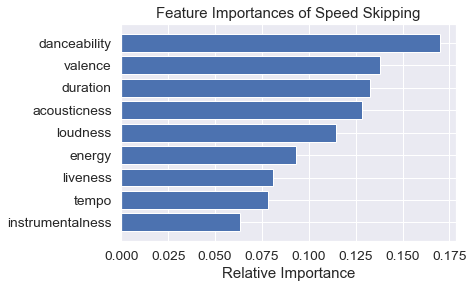

8.514723762051329


In [1014]:
tree_1=GradientBoostingClassifier(random_state=42,max_depth=3,n_estimators=110)
tree_1.fit(x_train,y_train)
tree_1.score(x_test,y_test)
features=x.columns
importance=tree_1.feature_importances_
indices=np.argsort(importance)

plt.title(f'Feature Importances of Speed Skipping')
#ax.subplot(1,3,j)
plt.barh(range(len(indices)),importance[indices],align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

print(log_loss(y_test,tree_1.predict(x_test)))

In [1015]:
tree_1.score(x_test,y_test)

0.7534791252485089

In [785]:
ratios=np.arange(0.9,0.99,0.005)
best_loss_dict=dict()
for ratio in ratios:
    logreg=LogisticRegression(multi_class='multinomial',solver='saga',penalty='elasticnet',l1_ratio=ratio).fit(x_train_p,y_train_p)
    logreg.predict_proba(x_valid)
    loss=log_loss(y_valid,logreg.predict_proba(x_valid))
    best_loss_dict[ratio]=loss

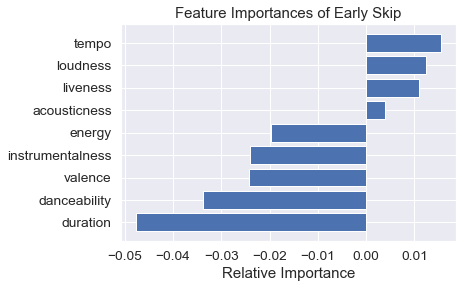

In [1011]:
best_loss_dict #Hence 0.96 is the best l1 ratio
logreg_2=LogisticRegression(multi_class='multinomial',solver='saga',penalty='elasticnet',l1_ratio=0.96).fit(x_train,y_train)
log_loss(y_test,logreg_2.predict_proba(x_test))

   
classes=['Early Skip']
#fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#fig=plt.figure((1,3,i))

features=df.columns[:-1]
importance=logreg_2.coef_[0]
indices=np.argsort(importance)

plt.title(f'Feature Importances of {classes[0]}')
#ax.subplot(1,3,j)
plt.barh(range(len(indices)),importance[indices],align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [1012]:
log_loss(y_test,logreg_2.predict_proba(x_test))
logreg_2.score(x_test,y_test)

0.7566032377165578

In [1013]:
tree_2=DecisionTreeClassifier(splitter='best',max_depth=3,random_state=42)
tree_2.fit(x_train,y_train)
fig=plt.figure(figsize=(20,15))
dot_data = tree.export_graphviz(tree_2, out_file=None, 
                      feature_names=df_.columns[:-1],  
                      class_names=['Late Skipped','Early skipped'],  
                      filled=True, rounded=True,special_characters=True)  
graph = graphviz.Source(dot_data)  
print(log_loss(y_test,tree_2.predict(x_test)))
graph.render(filename='g2.png')
graph
tree_2.score(x_test,y_test)

8.426438335882242


0.7560352172678216

<Figure size 1440x1080 with 0 Axes>

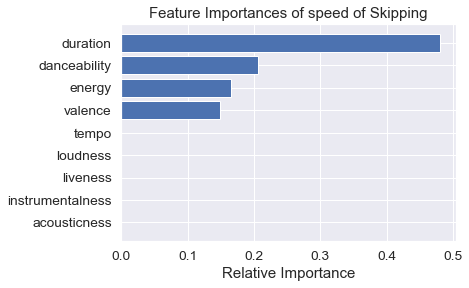

In [647]:
features=x.columns
importance=tree_2.feature_importances_
indices=np.argsort(importance)

plt.title(f'Feature Importances of speed of Skipping')
#ax.subplot(1,3,j)
plt.barh(range(len(indices)),importance[indices],align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [810]:
df

,duration,acousticness,danceability,energy,instrumentalness,liveness,loudness,tempo,valence,skip_speed,skip_at_all
0,356.600006,0.246817,0.682989,0.551150,2.120000e-05,0.047128,-10.164,124.584999,0.961799,0,0
1,285.746674,0.130157,0.649913,0.619879,6.250000e-08,0.076409,-8.437,78.024002,0.725308,2,1
2,285.746674,0.130157,0.649913,0.619879,6.250000e-08,0.076409,-8.437,78.024002,0.725308,1,1
3,249.119995,0.150626,0.760955,0.598114,2.588208e-03,0.031358,-5.838,103.977997,0.937014,2,1
4,228.923080,0.145012,0.792451,0.689618,9.070000e-09,0.098796,-7.118,130.057007,0.435938,2,1
...,...,...,...,...,...,...,...,...,...,...,...
19995,318.000000,0.000258,0.362474,0.701124,7.790000e-05,0.072693,-8.401,105.742996,0.190570,2,1
19996,318.000000,0.000258,0.362474,0.701124,7.790000e-05,0.072693,-8.401,105.742996,0.190570,2,1
19997,211.573334,0.313445,0.669488,0.510981,9.120000e-07,0.135029,-11.016,82.864998,0.398425,2,1
19998,211.684906,0.167160,0.784435,0.608155,1.340000e-10,0.087071,-5.885,90.712997,0.381874,2,1


In [846]:
df_=df.copy()

#with -1, skip at all is the target variable and with -2 skip_speed is the target variable
y=df_.iloc[:,-1]
x=df_.iloc[:,:-2]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=40,shuffle=True)

######### Fitting scaler on train data #########
scaler=StandardScaler()
scaler.fit(x_train)


######## Scaling both train and test #########
x_train= scaler.transform(x_train)
x_test= scaler.transform(x_test)

x_train_p,x_valid,y_train_p,y_valid=train_test_split(x_train,y_train,test_size=0.25,random_state=40,shuffle=True)

In [811]:
def Final_probabilities_tree(test_input):
    
    all_=[]
    for point in test_input:
        results=dict()
        no_skip_prob=tree_1.predict_proba(np.array([point]))[0][0]
        skip_prob=tree_1.predict_proba(np.array([point]))[0][1]
        late_skip_prob=tree_2.predict_proba(np.array([point]))[0][0]*skip_prob
        early_skip_prob=tree_2.predict_proba(np.array([point]))[0][1]*skip_prob
        
        results['no_skip_prob']=no_skip_prob
        results['late_skip_prob']=late_skip_prob
        results['early_skip_prob']=early_skip_prob
        
        all_.append(results)

    return all_
        

predicted_probabilties=Final_probabilities_tree(x_test)

def behaviour_tree(prob_dict):
    predicted_behaviour=[]
    for item in prob_dict:
        values=list(item.values())
        predicted_behaviour.append(values.index(max(values)))
        
    return predicted_behaviour

In [847]:
def Final_probabilities_Elasticnet(test_input):
    
    all_=[]
    for point in test_input:
        results=dict()
        no_skip_prob=logreg_1.predict_proba(np.array([point]))[0][0]
        skip_prob=logreg_1.predict_proba(np.array([point]))[0][1]
        #late_skip_prob=logreg_2.predict_proba(np.array([point]))[0][0]*skip_prob
        #early_skip_prob=logreg_2.predict_proba(np.array([point]))[0][1]*skip_prob
        
        results['no_skip_prob']=no_skip_prob
        results['skip_prob']=skip_prob
        #results['late_skip_prob']=late_skip_prob
        #results['early_skip_prob']=early_skip_prob
        
        all_.append(results)

    return all_
        

predicted_probabilties=Final_probabilities_tree(x_test)

def behaviour_Elasticnet(prob_dict):
    predicted_behaviour=[]
    for item in prob_dict:
        values=list(item.values())
        predicted_behaviour.append(values.index(max(values)))
        
    return predicted_behaviour
        

In [848]:
predicted=Final_probabilities_Elasticnet(x_test)
results=behaviour_Elasticnet(predicted)

In [861]:
y_true=np.array(pd.get_dummies(pd.DataFrame(y_test)['skip_at_all']))
y_pred=np.array(pd.get_dummies(pd.DataFrame(results)[0]))

In [875]:
y_pred=np.array(results)


In [876]:
y_true=np.array(y_test)

In [874]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as skm

In [877]:
confusion_matrix(y_true,y_pred)

array([[  15, 1446],
       [   7, 3532]])

In [878]:
cm = skm.multilabel_confusion_matrix(y_true, y_pred)
print(cm)
print(skm.classification_report(y_true,y_pred))

[[[3532    7]
  [1446   15]]

 [[  15 1446]
  [   7 3532]]]
              precision    recall  f1-score   support

           0       0.68      0.01      0.02      1461
           1       0.71      1.00      0.83      3539

    accuracy                           0.71      5000
   macro avg       0.70      0.50      0.42      5000
weighted avg       0.70      0.71      0.59      5000



In [880]:
log_loss(y_true,y_pred)

10.037199663937857

In [1094]:
a=pd.DataFrame(logreg_2.coef_,columns=['B_0','B_1','B_2','B_3','B_4','B_5','B_6','B_7','B_8',]).T
a.colnames='Coefficient Values'
a

,0
B_0,-0.047573
B_1,0.003921
B_2,-0.033735
B_3,-0.019800
B_4,-0.024146
B_5,0.010877
B_6,0.012336
B_7,0.015453
B_8,-0.024296


In [1079]:
logreg_2

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.96, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [1080]:
data

,duration,acousticness,danceability,energy,instrumentalness,liveness,loudness,tempo,valence,early,late
0,356.600006,0.246817,0.682989,0.551150,2.120000e-05,0.047128,-10.164,124.584999,0.961799,0,0
1,285.746674,0.130157,0.649913,0.619879,6.250000e-08,0.076409,-8.437,78.024002,0.725308,1,1
2,285.746674,0.130157,0.649913,0.619879,6.250000e-08,0.076409,-8.437,78.024002,0.725308,0,1
3,249.119995,0.150626,0.760955,0.598114,2.588208e-03,0.031358,-5.838,103.977997,0.937014,1,1
4,228.923080,0.145012,0.792451,0.689618,9.070000e-09,0.098796,-7.118,130.057007,0.435938,1,1
...,...,...,...,...,...,...,...,...,...,...,...
19995,318.000000,0.000258,0.362474,0.701124,7.790000e-05,0.072693,-8.401,105.742996,0.190570,1,1
19996,318.000000,0.000258,0.362474,0.701124,7.790000e-05,0.072693,-8.401,105.742996,0.190570,1,1
19997,211.573334,0.313445,0.669488,0.510981,9.120000e-07,0.135029,-11.016,82.864998,0.398425,1,1
19998,211.684906,0.167160,0.784435,0.608155,1.340000e-10,0.087071,-5.885,90.712997,0.381874,1,1
